In [4]:
import hist
import pandas as pd
import numpy as np
import awkward as ak
from coffea.analysis_tools import PackedSelection
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

In [5]:
# ---
# Sample: TTToSemiLeptonic: 1_280_000
fname = "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/120000/2A2F4EC9-F9BB-DF43-B08D-525B5389937E.root"
events = NanoEventsFactory.from_root(fname, entry_stop=1280000, schemaclass=NanoAODSchema).events()


print("Number of input events: {}".format(len(events)))

Number of input events: 1280000


# Objects: 

We will define the basic objects associated with top quark decay (2017).

<img src="Squema.png">
<img src="selected.png">
                   
                   

### Electron/Muon

|                 |    Electron       |    Muon     |
|-----------------|-------------------|-------------|
|  pT            | $\geq 30$         | $\geq 20$   |
| $|\eta|$        | $ < 2.4$          | $ < 2.4 $   |
| Electron ID     | CutBased $\geq 1$ |             |           
| Muon ID         |                   |  tight      |
| Muon Isolation  |                   |  $ > 0.15$  | 

A $\Delta R(e,\mu) > 0.4$ cut is included so as not to overlap between these objects.

The reconstructed objects will be stored in selected_object['electron'] and selected_object['muon'] as appropriate.







### FatJet


The information obtained from the FatJets will be used to identify tops and W.

[Click here](https://cmssdt.cern.ch/lxr/source/PhysicsTools/NanoAOD/python/nanoDQM_cfi.py)



#### Top Jet


|                           |    FatJet                 |
|---------------------------|---------------------------|
|  pT                      | $\geq 300$                | 
| $|\eta|$                  | $ < 2.4$                  | 
| Jet Id                    |  $ \geq 2 $               |               
| Top vs QCD Discriminator  | particleNet_TvsQCD $\geq 0.8$ | 


$\Delta R(e,top) > 0.8$ and $\Delta R(\mu,top) > 0.8$ are included so as not to overlap between these objects.

The reconstructed objects will be stored in selected_object['jetsTop'].



##### Jet Id
In nanoAOD format, jetId corresponds to the different working points.

- For 2016 samples:
    - jetId==1 means: pass loose ID, fail tight, fail tightLepVeto
    - jetId==3 means: pass loose and tight ID, fail tightLepVeto
    - jetId==7 means: pass loose, tight, tightLepVeto ID.

- For 2017 and 2018 samples:
    - jetId==2 means: pass tight ID, fail tightLepVeto
    - jetId==6 means: pass tight and tightLepVeto ID.

[Click here](https://twiki.cern.ch/twiki/bin/viewauth/CMS/JetID)

##### particleNet_TvsQCD: FatJets from top quarks (T) and QCD
values close to 1 indicate that the jet is more likely to come from a top quark, while values close to 0 indicate that the jet is more likely to come from the QCD.


#### W boson

|                                 |    FatJet                 |
|---------------------------------|---------------------------|
|  pT                            | $\geq 200$                | 
| $|\eta|$                        | $ < 2.4$                  | 
| Jet Id                          |  $ \geq 2 $               |                
| W vs QCD Discriminator          | particleNet_WvsQCD $ \geq 0.944$ |


$\Delta R(e,w) > 0.8$, $\Delta R(\mu,w) > 0.8$, and $\Delta R(top,w) > 0.8$ are included so as not to overlap between these objects.

The reconstructed objects will be stored in selected_object['jetsW'].


##### particleNet_TvsQCD: FatJets from top quarks (T) and QCD
values close to 1 indicate that the jet is more likely to come from a W boson, while values close to 0 indicate that the jet is more likely to come from the QCD.






### Jets

The information obtained from the Jets will be used to identify Jets and bjets.

#### Jets

|                                 |    Jet                 |
|---------------------------------|---------------------------|
|  pT                            | $\geq 20$                 | 
| $|\eta|$                        | $ < 2.5$                  | 
| Jet Id                          |  $ \geq 2 $               |                

The reconstructed objects will be stored in:
- selected_object['jets_noCleaned_against_boostedJets']: $\Delta R(e,jet) > 0.4$ and $\Delta R(\mu,jet) > 0.4$
- selected_object['jets_cleaned']: $\Delta R(e,jet) > 0.4$, $\Delta R(\mu,jet) > 0.4$, $\Delta R(top,jet) > 0.8$, and $\Delta R(w,jet) > 0.8$



#### bjets

We use the previously filtered Jets and add the DeepFlav criterion.


|                                 |    Jet                 |
|---------------------------------|---------------------------|
| $|\eta|$                        | $ < 2.5$                  | 
| btagDeepFlavB                   | Medium                    | 


The reconstructed objects will be stored in selected_object['jetsB'].


##### btagDeepFlavB: Deep Flavor algorithm

*** TLorentz objects: [Click here](https://coffeateam.github.io/coffea/api/coffea.nanoevents.methods.vector.LorentzVector.html)

In [6]:
 selected_object = {'muon': [], 'electron': [],                       # Leptons
                    'jetsTop': [],                                    # FatJet
                    'jetsW': [],                                      # WJet
                    'jets_noCleaned_against_boostedJets': [],         # No overlap with Electrons and Muons
                    'jets_cleaned': [],                               # No overlap with FatJet, WJet, Electrons and Muons
                    'jetsB': []                                       # BJet
                   }
    
selections = PackedSelection()

In [7]:
##############################################
######  Definition of the objects ############
##############################################

# ------------
# Electrons
# ------------

good_electrons = (
    (events.Electron.pt >= 30)
    & (np.abs(events.Electron.eta) < 2.4)
    & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
    & (events.Electron.cutBased >= 1)
)


leading_electron = ak.firsts(events.Electron[good_electrons])

# Events
n_good_electrons = ak.sum(good_electrons, axis=1)
electrons = events.Electron[(good_electrons & n_good_electrons == 1)]


# Selections
selections.add("one_electron", n_good_electrons == 1)
    
    
    

# ------------
# Muons
# ------------

good_muons = (
    (events.Muon.pt >= 20)
    & (np.abs(events.Muon.eta) < 2.4)
    & (events.Muon.tightId)
    & (events.Muon.pfRelIso04_all > 0.15)
)

# Check that muons don't overlap with electrons (DeltaR > 0.4)
leading_muon = ak.firsts(events.Muon[good_muons])
overlap_muon_electron = leading_muon.delta_r(leading_electron) > 0.4


# Events
n_good_muons = ak.sum(good_muons, axis=1)
muons = events.Muon[(good_muons & overlap_muon_electron & n_good_muons == 1)]


# Selections
selections.add("one_muon", n_good_muons == 1)
selections.add("muon_electron_dr", overlap_muon_electron)


In [8]:
# -----
# Fat Jets
# -----

# Loose: L subindex.
# Medium: M subindex.
# Tight: T subindex.
# Nomenclature: "year": [jetd_id, pNet_id_L, pNet_id_M, pNet_id_T]
    
constants_as_fuction_wp_fatjet = {
                            "2016" : [3, 0.50, 0.73, 0.96], 
                            "2016APV" : [3, 0.49, 0.74, 0.96], 
                            "2017": [2, 0.58, 0.80, 0.97], 
                            "2018": [2, 0.58, 0.80, 0.97]
                        }


jet_id = constants_as_fuction_wp_fatjet["2017"][0]
pNet_id = constants_as_fuction_wp_fatjet["2017"][2]


# Select good fat jets
good_fatjets = (
    (events.FatJet.pt >= 300)
    & (np.abs(events.FatJet.eta) <= 2.4)
    & (events.FatJet.particleNet_TvsQCD >= pNet_id)   # Medium   (Top vs QCD)
    & (events.FatJet.jetId >= jet_id)   # Medium
)

leading_top = ak.firsts(events.FatJet[good_fatjets])
# check that top don't overlap with electrons and muons (DeltaR > 0.8)
overlap_top_electron = leading_top.delta_r(leading_electron) > 0.8
overlap_top_muon = leading_top.delta_r(leading_muon) > 0.8 


# Events
n_good_fatjets = ak.sum(good_fatjets, axis=1)
tops = events.FatJet[(good_fatjets & overlap_top_electron & overlap_top_muon)]



# Selections
selections.add("one_top", n_good_fatjets == 1)
selections.add("top_electron_dr", overlap_top_electron)
selections.add("top_muon_dr", overlap_top_muon)

In [9]:
# -----
# Top Jets
# -----
    
# Loose: L subindex.
# Medium: M subindex.
# Tight: T subindex.
# Nomenclature: "year": [jetd_id, pNet_id_L, pNet_id_M, pNet_id_T]
    
constants_as_fuction_wp_wjet = {
                            "2016" : [3, 0.68, 0.94, 0.97], 
                            "2016APV" : [3, 0.67, 0.93, 0.97], 
                            "2017": [2, 0.71, 0.94, 0.98], 
                            "2018": [2, 0.70, 0.94, 0.98]
                        }

jet_id = constants_as_fuction_wp_wjet["2017"][0]
pNet_id = constants_as_fuction_wp_wjet["2017"][2]

good_wjets = (
    (events.FatJet.pt >= 200)
    & (np.abs(events.FatJet.eta) <= 2.4) #This is the recommendation for all the fat jets (there are not reconstructed forward fat jets)
    & (events.FatJet.jetId >= jet_id)   
    & (events.FatJet.particleNet_WvsQCD >= pNet_id)   # Medium  (W vs QCD)
)


leading_wjet = ak.firsts(events.FatJet[good_wjets])
# Leading wjet don't overlap with electrons, muons (DeltaR > 0.8) and topJets (Delta R > 0.8) 
overlap_w_electron = leading_wjet.delta_r(leading_electron) > 0.8
overlap_w_muon = leading_wjet.delta_r(leading_muon) > 0.8 
overlap_w_top = leading_wjet.delta_r(leading_top) > 0.8 

# Events
n_good_wjets = ak.sum(good_wjets, axis=1) 
wjets = events.FatJet[(good_wjets & overlap_w_electron & overlap_w_muon & overlap_w_top & n_good_wjets == 1)]


# Selections
selections.add("one_w", n_good_wjets == 1) 
selections.add("two_w", n_good_wjets == 2)   # we have two tops, so we will have 2 W (see decay squema)
selections.add("w_electron_dr", overlap_w_electron)
selections.add("w_muon_dr", overlap_w_muon)
selections.add("w_top_dr", overlap_w_top)


In [11]:
# -----
# Jets and bjets
# -----
    
# Nomenclature: "year": [jetd_eta, jet_id, b_jet_id_L, b_jet_id_M, b_jet_id_T]

constants_as_fuction_wp_jet = {
                            "2016" : [2.4, 3,  0.0480, 0.2489, 0.6377], 
                            "2016APV" : [2.4, 3, 0.0508, 0.2598, 0.6502], 
                            "2017": [2.5, 2, 0.0532, 0.3040, 0.7476], 
                            "2018": [2.5, 2, 0.0490, 0.2783, 0.7100]
                        } 



jet_eta = constants_as_fuction_wp_jet["2017"][0]
jet_id = constants_as_fuction_wp_jet["2017"][1]


good_jets = (
        (events.Jet.pt >= 20)
        & (np.abs(events.Jet.eta) <= jet_eta) 
        & (events.Jet.jetId >= jet_id)   
)     



bjet_wp = constants_as_fuction_wp_jet["2017"][3]   # wp deppFlavour (medium)

good_bjets = (
                events.Jet.btagDeepFlavB >= bjet_wp
            )


leading_jet = ak.firsts(events.Jet[good_jets])
# Leading jet don't overlap with electrons, muons (DeltaR > 0.4), topJets and jets (Delta R > 0.8) 
overlap_jet_electron = leading_jet.delta_r(leading_electron) > 0.4
overlap_jet_muon = leading_jet.delta_r(leading_muon) > 0.4
overlap_jet_top = leading_jet.delta_r(leading_top) > 0.8
overlap_jet_w = leading_jet.delta_r(leading_wjet) > 0.8



# Events
n_good_jets = ak.sum(good_jets, axis=1) 
n_good_bjets = ak.sum(good_bjets, axis=1) 
jets_NC = events.Jet[(good_jets & overlap_jet_electron & overlap_jet_muon)]
jets = events.Jet[(good_jets & overlap_jet_electron & overlap_jet_muon & overlap_jet_top & overlap_jet_w)]
bjets = events.Jet[(good_jets & good_bjets & overlap_jet_electron & overlap_jet_muon & overlap_jet_top & overlap_jet_w & n_good_bjets == 1)]



# Selections
selections.add("two_jets", n_good_jets == 2)   # When one top decay we have two jets (see decay squema)
selections.add("one_bjet", n_good_bjets == 1)   
selections.add("jet_electron_dr", overlap_jet_electron)
selections.add("jet_muon_dr", overlap_jet_muon)
selections.add("jet_top_dr", overlap_jet_top)
selections.add("jet_wjet_dr", overlap_jet_w)

In [13]:
##############################################
######  Auxiliar function  ###################
##############################################

def number_entries(object):  
   
    num_none = ak.count_nonzero(ak.num(object) == 0)  # Number of empty entries.
    total = len(object)
    n = total - num_none
    
    return "passed the criteria = {} events".format(n)

In [14]:

##############################################
######  Objects identified ###################
##############################################


objects = {
        "electron": ["one_electron"],
        "muon": ["one_muon", "muon_electron_dr"],
        "jetsTop": ["one_top", "top_electron_dr", "top_muon_dr"],
        "jetsW": ["one_w", "w_electron_dr", "w_muon_dr", "w_top_dr"],
        "jets_NC": ["two_jets", "jet_electron_dr", "jet_muon_dr"],
        "jets_cleaned": ["two_jets", "jet_electron_dr", "jet_muon_dr", "jet_top_dr", "jet_wjet_dr"],
        "jetsB": ["one_bjet", "jet_electron_dr", "jet_muon_dr", "jet_top_dr", "jet_wjet_dr"]
    }

print("Total input events {}".format(len(events)))

selected_object['electron'].append(electrons)
selected_object['electron'].append(selections.all(*objects["electron"]))
print("Number of electrons that " + number_entries(selected_object['electron'][0]))


selected_object['muon'].append(muons)
selected_object['muon'].append(selections.all(*objects["muon"]))
print("Number of muons that " + number_entries(selected_object['muon'][0]))


selected_object['jetsTop'].append(tops)
selected_object['jetsTop'].append(selections.all(*objects["jetsTop"]))
print("Number of tops that " + number_entries(selected_object['jetsTop'][0]))


selected_object['jetsW'].append(wjets)
selected_object['jetsW'].append(selections.all(*objects["jetsW"]))
print("Number of ws that " + number_entries(selected_object['jetsW'][0]))


selected_object['jets_noCleaned_against_boostedJets'].append(jets_NC)
selected_object['jets_noCleaned_against_boostedJets'].append(selections.all(*objects["jets_NC"]))
print("Number of jets_NC that " + number_entries(selected_object['jets_noCleaned_against_boostedJets'][0]))


selected_object['jets_cleaned'].append(jets)
selected_object['jets_cleaned'].append(selections.all(*objects["jets_cleaned"]))
print("Number of jets that " + number_entries(selected_object['jets_cleaned'][0]))


selected_object['jetsB'].append(bjets)
selected_object['jetsB'].append(selections.all(*objects["jetsB"]))
print("Number of bjets that " + number_entries(selected_object['jetsB'][0]))

Total input events 1280000
Number of electrons that passed the criteria = 245717 events
Number of muons that passed the criteria = 1279477 events
Number of tops that passed the criteria = 1279667 events
Number of ws that passed the criteria = 1279918 events
Number of jets_NC that passed the criteria = 1272422 events
Number of jets that passed the criteria = 1279934 events
Number of bjets that passed the criteria = 1279924 events


# Top's reconstruction 

- In order to reconstruct the top and wjets, a validity interval will be defined depending on each case considered.

- The chi-square criterion will be applied to define whether or not an event passes the top tagger.
    
$$ \chi^{2} = \left[\frac{m(t)_{(reconstructed)} - m(t)_{(pdg)}}{\sigma_{top}}\right]^2 + \left[\frac{m(w)_{(reconstructed)} - m(w)_{(pdg)}}{\sigma_{w}}\right]^2 < 5 $$ 


Where:
$m(t)_{(pdg)} = 173.1$;   $m(w)_{(pdg)} = 80.4$. $\sigma_{w}$ and $\sigma_{t}$ and the reconstructed masses depend on the case under consideration .


- We will work with some dictionaries that will be useful.
    
    * pdg_masses = [top_mass_pdg, w_mass_pdg, muon_mass_pdg, electron_mass_pdg]
    
    
    * results = {'top reconstructed', 'w reconstructed', 'top_topology_decay'= {0,1,2,3}, 'chi2'}
    
Where 0 = boosted top; 1 = Partially boosted; 2 = Hadronic top; 3 = leptonic top.
    
    
    * masses_sigmas_chi2 = {top_sigma, top_low, top_down, w_sigma, w_low, w_up, chi2}
    
Each value depends of the topology decay.

    * all_combinations_results = {'top reconstructed', 'w reconstructed', 'top_topology_decay'= {0,1,2,3}, 'chi2', 'top_AK4jets'}
    
    

### Boosted top: t

We use the information stored as jetsTop in our selected_object. With such objects, we determine the mass for each jetsTop and compare it with the range defined by:

##### Mass ranges

- $m_{t} = [100, 400]$


The function that perform the filters is defined by boosted_top(jetsTop,masses_sigmas_chi2, results). Results will be stored in results = {}.



### Partially-boosted top: t -> W b

We take the wjets and bjets previously defined from the FatJet and see if it meets the criterion that the reconstructed mass between these objects is in the mass window defined for the top. 


It is worth mentioning that a criterion based on the definition of a mass window will also be applied in order to correctly choose the w.


The function that perform the filters is defined by partially_boosted_top(jetsW, jetsB, masses_sigmas_chi2, all_combinations_results). 



Results will be stored in all_combinations_results = {}.

##### Mass ranges

- $m_{t} = [100, 300]$
- $m_{w} = [40, 200]$

##### $\sigma$ ranges

- $\sigma_{t} = 37.14 $
- $\sigma_{w} = 20.09 $

##### $\chi^{2}_{ref} == 5$

### Resolved hadronic top: t -> W(q q) b 
The idea is to perform the recontruction of the top using the information from 2 jets and 1 b-jet, where the two jets are the consequence of a hadronic decay of the W.


To select the two jets we consider events whose reconstructed mass of the two jets is in the window defined by mass mw(min) and mw(max). Events that pass the above filter are combined with the b-jet to reconstruct the top.


The function that perform the filters is defined by 
hadronic_top(jets_cleaned, jetsB, masses_sigmas_chi2, all_combinations_results). 



Results will be stored in all_combinations_results = {}.

##### Mass ranges

- $m_{t} = [100, 300]$
- $m_{w} = [40, 200]$

##### $\sigma$ ranges

- $\sigma_{t} = 35.02 $
- $\sigma_{w} = 24.98 $

##### $\chi^{2}_{ref} == 5$

### Resolved leptonic top: top -> W(l nu) b

Similar to the previous case, we perform the recontruction of the top using a lepton (l) plus neutrino (nu) in the final state, where l y nu rebuilt the W boson.


We consider events whose reconstructed mass of the lepton and nuetrino is in the mass window defined by mw(min) and mw(max). Events that pass the above filter are combined with the b-jet to reconstruct the top.


The function that perform the filters is defined by 
def single_leptonic_top(events, muon, electron, jetsB, masses_sigmas_chi2, pdg_masses, all_combinations_results). $\textbf{We use events as input since we have to work with the MET.}$


Results will be stored in all_combinations_results = {}.

##### Mass ranges

- $m_{t} = [100, 600]$
- $m_{w} = [40, 600]$


##### $\sigma$ ranges

- $\sigma_{t} = 120.8 $
- $\sigma_{w} = 127.2 $

##### $\chi^{2}_{ref} == 5$


# Results

Results that pass the criteria for building a top will be stored in the results{} dictionary.

$$ results = \left\{top; w; topology; \chi^{2}\right\} $$

- Top: Top reconstructed.
- Topology: Boosted top; Partially-boosted top; Resolved hadronic top; Resolved leptonic top.


$$ all\_combinations\_results =  {\cdots}$$


In [124]:
##############################################
######  Auxiliar functions ###################
##############################################

# -------------------
# calculate chi2
# -------------------
def chi2_test(topJet, wJet, masses_sigmas_chi2, pdg_masses):

    # PDG values
    top_mass_pdg = pdg_masses[0]
    w_mass_pdg = pdg_masses[1]
    
    
    # Sigmas
    top_sigma = masses_sigmas_chi2["Partially-boosted top"][0]
    w_sigma = masses_sigmas_chi2["Partially-boosted top"][3]
    
    t = (ak.firsts(topJet.mass) - top_mass_pdg) / top_sigma
    w = (ak.firsts(wJet.mass) - w_mass_pdg) / w_sigma
    
    chi2_cal = t**2 + w**2
    
    
    # chi2 criteria
    chi2_ref = masses_sigmas_chi2["Partially-boosted top"][6]

    
    top_chi2 = topJet[(chi2_cal < chi2_ref)]
    w_chi2 = wJet[(chi2_cal < chi2_ref)]
    
    return top_chi2, w_chi2


# ---------------
# add_results
# ---------------
def add_results(w, top, topology, all_combinations_results):
    all_combinations_results['top'].append(top)
    all_combinations_results['w'].append(w)
    all_combinations_results['top_topology_decay'].append(topology)
    
    
    
histogram_boosted = hist.Hist(
    hist.axis.Regular(
        bins=25, start=50, stop=500, name="mtop", label="$m_{top}$ [GeV]"
    ),
)


histogram_partially_boosted = hist.Hist(
    hist.axis.Regular(
        bins=25, start=50, stop=500, name="mtop", label="$m_{top}$ [GeV]"
    ),
)


histogram_hadronic = hist.Hist(
    hist.axis.Regular(
        bins=25, start=50, stop=500, name="mtop", label="$m_{top}$ [GeV]"
    ),
)


In [79]:
# PDG values

# Nomenclature: [top_mass_pdg, w_mass_pdg, muon_mass_pdg, electron_mass_pdg]

pdg_masses = [173.1, 80.4, 0.10566, 0.511e-3]


# Nomenclature: [top_sigma, top_low, top_down, w_sigma, w_low, w_up, chi2]
masses_sigmas_chi2 = {
                        "boosted top" : [37.14, 100, 400],
                        "Partially-boosted top" : [37.14, 100, 300, 20.09, 37.14, 20.09, 5],
                        "Resolved hadronic top" : [35.02, 100, 300, 24.98, 40, 200, 5],
                        "Resolved leptonic top" : [120.8, 100, 600, 127.2, 40, 600, 5]
                    }


# Results will be stored in results{}
results ={
          'top':[], 
          'w':[], 
          'top_topology_decay':[], 
          'chi2':[]
         }



all_combinations_results = {
                            'top':[],
                            'w':[],
                            'top_topology_decay':[],
#                            'chi2':[],
#                            'top_AK4jets':[]
                            }

In [80]:
###################################
########### Boosted top ###########
###################################

# reconstruct the boosted top
def boosted_top(jetsTop, 
                masses_sigmas_chi2,
                results):
                    
        
    top_mass_low = masses_sigmas_chi2["boosted top"][1]
    top_mass_up =  masses_sigmas_chi2["boosted top"][2]
    

    good_top_mass = (
        (jetsTop.mass > top_mass_low)
        & (jetsTop.mass < top_mass_up)
    )
    
    
    boosted_top = jetsTop[good_top_mass]   
    
    results['top'].append(boosted_top)
    results['w'].append(TLorentzVector(0,0,0,0))    # append(ROOT.TLorentzVector(0, 0, 0, 0))  # https://coffeateam.github.io/coffea/api/coffea.nanoevents.methods.vector.LorentzVector.html
    results['top_topology_decay'].append(0)
    results['chi2'].append(0.0000001)

    

Number of entries in the function passed the criteria = 1279663 events
Number of boosted tops passed the criteria = 1279663 events


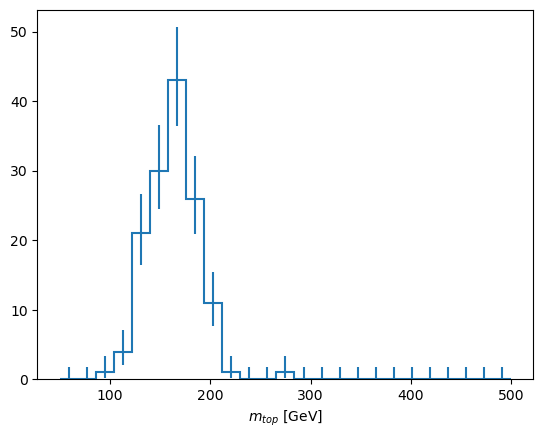

In [81]:
# Check the boosted tops: FatJets are identified as Top Jets
boosted_top(selected_object['jetsTop'][0], masses_sigmas_chi2, results)

print("Number of entries in the function " + number_entries(results['top'][0]))
print("Number of boosted tops " + number_entries(results['top'][0]))


histogram_boosted.fill(mtop=ak.fill_none(ak.flatten(results['top'][0].mass), False)).plot1d();

In [181]:
# reconstruct partially-boosted top
def partially_boosted_top(jetsW, 
                          jetsB, 
                          masses_sigmas_chi2,
                          all_combinations_results):
    
    
    top_mass_low = masses_sigmas_chi2["Partially-boosted top"][1]
    top_mass_up = masses_sigmas_chi2["Partially-boosted top"][2]
    
   
    w_mass_low = masses_sigmas_chi2["Partially-boosted top"][4]
    w_mass_up = masses_sigmas_chi2["Partially-boosted top"][5]

    chi2 = masses_sigmas_chi2["Partially-boosted top"][6]
    
    
    
    
    # Recosntructable mass of the w
    good_w_mass = (
        (jetsW.mass > w_mass_low)
        & (jetsW.mass < w_mass_up)
    )
    
    
    jetsW_filtered = jetsW[good_w_mass]
    jetsB_filtered = jetsB[good_w_mass]
    
    # Adding the 4momentum of w and bjet.
    bjet_plus_wjet = jetsW_filtered + jetsB_filtered
    
    # Recosntructable mass between w and bottom.
    good_b_w_mass = (
        (bjet_plus_wjet.mass > top_mass_low)
        & (bjet_plus_wjet.mass < top_mass_up)
    )
    
    partially_boosted_top = bjet_plus_wjet[good_b_w_mass]
    wJets = jetsW_filtered[good_b_w_mass]
    
    
    # Chi^2 test   
    top_chi2, w_chi2 = chi2_test(partially_boosted_top, wJets, masses_sigmas_chi2, pdg_masses)
    

    add_results(w_chi2, top_chi2, 1, all_combinations_results)

/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


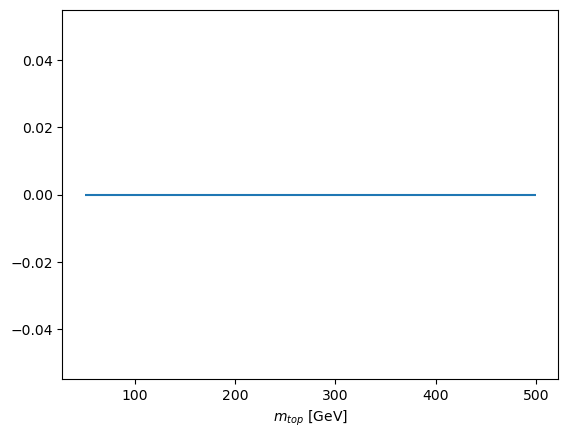

In [182]:
# Check the partially boosted tops: One W jet plus one b Jet are identified as one Top Jet.
partially_boosted_top(selected_object['jetsW'][0], selected_object['jetsB'][0], masses_sigmas_chi2, all_combinations_results)

"""
print("Number of W entries in the function " + number_entries(selected_object['jetsW'][0]))
print("Number of B-Jets entries in the function " + number_entries(selected_object['jetsB'][0]))

print("Number of tops reconstructed " + number_entries(all_combinations_results['top'][0]))
"""

histogram_partially_boosted.fill(mtop=ak.fill_none(ak.flatten(all_combinations_results['top'][0].mass), False)).plot1d();

In [175]:
# reconstruct hadronic top *****************
def hadronic_top(jets_cleaned,         
                 jetsB,         
                 masses_sigmas_chi2,
                 all_combinations_results):


    top_mass_low = masses_sigmas_chi2["Partially-boosted top"][1]
    top_mass_up = masses_sigmas_chi2["Partially-boosted top"][2]
    
    
    bjet_wjet, wjet = hadronic_w(jets_cleaned, jetsB, masses_sigmas_chi2)
    
    
    good_tops = (
            (bjet_wjet.mass > top_mass_low)
            & (bjet_wjet.mass < top_mass_up)
    )
    
    
    # --- a preserve las dimensiones de la máscara m, podés escribir a.mask[b]
    hadronic_tops = bjet_wjet[good_tops]
    w_filtered = wjet.mask[good_tops]

    # Chi^2 test   
    top_chi2, w_chi2 = chi2_test(hadronic_tops, w_filtered, masses_sigmas_chi2, pdg_masses)


    add_results(w_chi2, top_chi2, 2, all_combinations_results)   


    
# reconstruct resolved hadronic top ****************
def hadronic_w(jets_cleaned,   
               jetsB,
               masses_sigmas_chi2): 
    
        
    w_mass_low = masses_sigmas_chi2["Partially-boosted top"][4]
    w_mass_up = masses_sigmas_chi2["Partially-boosted top"][5]
    
    
    jet_1 = ak.firsts(jets_cleaned)
    jet_2 = ak.pad_none(jets_cleaned, 2)[:, 1]
    
    # reconstructed mass between the two jets (Will they reconstruct the w mass?)
    jets = jet_1 + jet_2
    
    good_w = (
            (w_mass_low < jets.mass)
            & (jets.mass < w_mass_up)
    )    
        
        
    # wjets reconstructed
    wjets_filtered = jets[good_w]
    bjets_filtered = jetsB[good_w] # We have set up events where we have both particles at the same time.
        
    bjet_plus_wjet = wjets_filtered + bjets_filtered
    
    
    return bjet_plus_wjet, wjets_filtered

/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


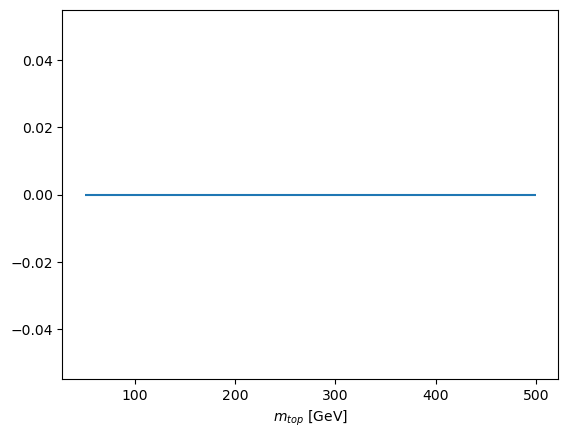

In [176]:
# Check the hadronic tops
hadronic_top(selected_object['jets_cleaned'][0], selected_object['jetsB'][0], masses_sigmas_chi2, all_combinations_results)

"""
print("Number of jets entries in the function " + number_entries(selected_object['jets_cleaned'][0]))
print("Number of B-Jets entries in the function " + number_entries(selected_object['jetsB'][0]))
"""

histogram_hadronic.fill(mtop=ak.fill_none(ak.flatten(all_combinations_results['top'][0].mass), False)).plot1d();

Variables of interest to be used.

$$ E = \sqrt{p_{T}^2 + p_z^2 + m^2} = \sqrt{|p|^2 + m^2} $$

$$ a = m(w)_{pdg}^2 + m(l)_{pdg}^2 + 2\left[p_{x}(l)*MET(x) +  p_{y}(l)*MET(y)\right] $$

$$ A = 4 \left[E^{2} - p_z^2 \right] $$
$$ B = -4 a p_z^2 $$
$$ C = 4 \left[E^{2} + MET(x)^2 + MET(y)^2 - a^2 \right] $$

In [25]:
###################################
###### Resolved leptonic top ######
###################################


def single_leptonic_top(MET, 
                        muon, 
                        electron, 
                        lepton,
                        jetsB, 
                        masses_sigmas_chi2,
                        pdg_masses,
                        all_combinations_results):
    
    
    top_mass_low = masses_sigmas_chi2["Resolved leptonic top"][1]
    top_mass_up = masses_sigmas_chi2["Resolved leptonic top"][2]
    
    
    if lepton == "ele":
        lepton =  ak.flatten(electron)
        lepton_mass_pdg = pdg_masses[2]
        
    elif lepton == "mu":
        lepton = ak.flatten(muon)
        lepton_mass_pdg = pdg_masses[3]
    
       
        
    if (len(lepton) != 0):
        
        metpz = met_pz(MET, lepton, pdg_masses, lepton_mass_pdg)
        
        good_event = metpz != 0
        
        
        met_filter = MET[good_event]
        lepton_filter = lepton[good_event]
    
        single_leptonic_w(met_filter, lepton_filter, masses_sigmas_chi2)
        
        l_nu_mass = (lepton + met).mass
    
    """
    
    if((len(muon) + len(electron)) == 1):
        metpz = met_pz(events, pdg_masses, lepton_mass_pdg, lepton)
        metE = np.sqrt(events.MET.pt ** 2 + metpz ** 2)
        neutrino = TLorentzVector(event.MET_pt * math.cos(event.MET_phi), event.MET_pt * math.sin(event.MET_phi), metpz, metE) # Revisar el 4vector
        
        single_leptonic_w(lepton, neutrino, masses_sigmas_chi2, leptonic_w_mass)

        # Reconstructable mass bjet.
        good_b_mass = (
            (jetsB.mass > top_mass_low)
            & (jetsB.mass < top_mass_up)
        )
        
        leptonic_tops = jetsB[good_b_mass]
    """
    """
        # Chi^2 test
        chi2 = masses_sigmas_chi2["Partially-boosted top"][6]
                
        chi2_lep = []   
                
        chi2_a = chi2(jetsB.mass, leptonic_w_mass, masses_sigmas_chi2, pdg_masses)
                
        if chi2_a < chi2:
            chi2_lep.append(chi2a)
                    
            add_results(chi2_lep, 
                        leptonic_tops,
                        lepton, neutrino,
                        all_combinations_results,
                        3)
    """
        
        


# using MET to calculate the metpz
def met_pz(MET,
           lepton,
           pdg_masses,
           lepton_mass_pdg):
    
    # With this function we will correct met_pz
    w_mass_pdg = pdg_masses[1]
    
    met = MET[lepton.pt > 0] # We have set up events where we have both particles at the same time.
    
    
    # Componentes (MET and lepton) 
    met_px, met_py, met_pz = momentum_components(met)
    lepton_px, lepton_py, lepton_pz = momentum_components(lepton) 
    lepton_energy = np.sqrt(lepton.pt ** 2 + lepton_pz ** 2 + lepton.mass ** 2) 
    
    
    
    # Quadratic equation
    a = math.pow(w_mass_pdg,2) - math.pow(lepton_mass_pdg,2) + 2.0 * (lepton_px * met_px + lepton_py * met_py)
    
    
    A = 4.0 * (lepton_energy ** 2 - lepton_pz ** 2)
    B = -4.0 * a * lepton_pz
    C = 4.0 * (lepton_energy ** 2 + met_px ** 2 + met_py ** 2) - a ** 2
    
    met_pz = quadratic_sol_metpz(A,B,C, lepton_pz) # We will conserve the smaller solution.
    
    
    return met_pz
    



# reconstruct the resolved leptonic W (muon decay)
def single_leptonic_w(lepton, 
                      met, 
                      masses_sigmas_chi2):
    
    w_mass_low = masses_sigmas_chi2["Resolved leptonic top"][4]
    w_mass_up = masses_sigmas_chi2["Resolved leptonic top"][5]
    
    
    l_nu_mass = (lepton + met).mass    
    
    
    if (w_mass_low < l_nu_mass < w_mass_up):  
        w_mass = l_nu_mass
        
    else:
        w_mass = 9999
        
    #leptonic_w_mass.append(w_mass)


In [35]:
# Check the leptonic top
single_leptonic_top(events,selected_object['muon'][0], selected_object['electron'][0], selected_object['jetsB'][0], masses_sigmas_chi2, pdg_masses, all_combinations_results)

#histogram_lep.fill(mtop=ak.fill_none(ak.flatten(all_combinations_results['top'][0].mass), False)).plot1d();

In [37]:
##################################################
##############  Main function ####################
##################################################

def topsXFinder(events, 
                selected_idx, 
                top_type, 
                masses_sigmas_chi2,
                pdg_masses,
                results):
    
    ################# 0. pick out the boosted top #################
  
    
    if (top_type['boosted_top']):         
        boosted_top(events, 
                    selected_idx['jetsTop'], 
                    masses_sigmas_chi2,
                    results)
        

    ################# 1. partially-boosted top #######################

    if (top_type['partially_boosted_top']):      
        partially_boosted_top(events, 
                              selected_idx['jetsW'],
                              selected_idx['jetsB'], 
                              masses_sigmas_chi2,
                              all_combinations_results)

    

    ################## 2. resolved hadronic top ######################
    
    if (top_type['hadronic_top']): 
        hadronic_top(events, 
                     selected_idx['jets_cleaned'], 
                     selected_idx['jetsB'],
                     masses_sigmas_chi2,
                     all_combinations_results)

        
    ################## 3. resolved leptonic top ######################
    
    if (top_type['leptonic_top']): 
        single_leptonic_top(events, 
                            selected_idx['muon'], 
                            selected_idx['electron'],
                            selected_idx['jetsB'], 
                            masses_sigmas_chi2,
                            pdg_masses,
                            all_combinations_results)
        